In [49]:
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import RobustScaler,StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import importlib
from sklearn.decomposition import PCA

path_src = os.path.abspath('../../../src')

# Agregar esa ruta al sys.path si no está ya
if path_src not in sys.path:
    sys.path.append(path_src)

# Importar utils normalmente
import utils
importlib.reload(utils)

# Importar funciones específicas
from utils import (
    run_agglomerative_mlflow,
    transform_pca,
    silhouette_analysis_agglomerative,
    elbow_method_agglomerative,
    plot_davies_bouldin_scores_agglomerative,
    evaluar_calinski_harabasz_agglomerative
)


In [50]:
rfm_clientes_locales = pd.read_csv('../../../dataset/rfm_clientes_extranjeros.csv')



print(rfm_clientes_locales.columns)

print("cantidad de columnas: ", len(rfm_clientes_locales.columns))

print("cantidad de filas: ", len(rfm_clientes_locales))

Index(['id_cliente', 'Recency', 'Frequency', 'Monetary', 'horario_promedio',
       '2010-12', '2011-01', '2011-02', '2011-03', '2011-04', '2011-05',
       '2011-06', '2011-07', '2011-08', '2011-09', '2011-10', '2011-11',
       '2011-12'],
      dtype='object')
cantidad de columnas:  18
cantidad de filas:  418


In [51]:
rfm_clientes_locales.head()

,id_cliente,Recency,Frequency,Monetary,horario_promedio,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12
0,12347.0,3,7,4310.00,12,711.79,475.39,0.0,0.00,636.25,0.0,382.52,0.0,584.91,0.0,1294.32,0.00,224.82
1,12348.0,76,4,1437.24,15,652.80,187.44,0.0,0.00,327.00,0.0,0.00,0.0,0.00,270.0,0.00,0.00,0.00
2,12349.0,19,1,1457.55,9,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,1457.55,0.00
3,12350.0,311,1,294.40,16,0.00,0.00,294.4,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.00
4,12352.0,37,7,1385.74,14,0.00,0.00,296.5,345.01,0.00,0.0,0.00,0.0,0.00,512.5,0.00,231.73,0.00


In [52]:
# Limpieza de outliers usando el método IQR para Recency, Frequency y Monetary
def remove_outliers_iqr(df, columns):
    """
    Elimina outliers usando el método IQR (Interquartile Range)
    """
    df_clean = df.copy()
    
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filtramos los outliers
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    
    return df_clean

# Columnas a limpiar
columns_to_clean = ['Recency', 'Frequency', 'Monetary']

# Mostrar estadísticas antes de la limpieza
print("Estadísticas ANTES de la limpieza de outliers:")
print(rfm_clientes_locales[columns_to_clean].describe())
print(f"\nCantidad de registros antes: {len(rfm_clientes_locales)}")

# Aplicar limpieza de outliers
rfm_clientes_locales_clean = remove_outliers_iqr(rfm_clientes_locales, columns_to_clean)




Estadísticas ANTES de la limpieza de outliers:
          Recency   Frequency       Monetary
count  418.000000  418.000000     418.000000
mean    96.409091    4.361244    3575.053397
std    104.434586   11.182426   17389.197213
min      1.000000    1.000000      45.000000
25%     19.250000    1.000000     408.235000
50%     54.000000    2.000000     927.930000
75%    138.500000    4.000000    2408.952500
max    374.000000  198.000000  279138.020000

Cantidad de registros antes: 418


In [53]:
id_cliente= rfm_clientes_locales_clean['id_cliente'].copy()

id_cliente.head()

1    12348.0
2    12349.0
3    12350.0
4    12352.0
5    12353.0
Name: id_cliente, dtype: float64

In [54]:
rfm_clientes_locales_clean.drop(columns=['id_cliente'], inplace=True)

In [55]:
rfm_clientes_locales_clean

,Recency,Frequency,Monetary,horario_promedio,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12
1,76,4,1437.24,15,652.8,187.44,0.00,0.00,327.0,0.0,0.00,0.00,0.00,270.0,0.0,0.00,0.0
2,19,1,1457.55,9,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,1457.55,0.0
3,311,1,294.40,16,0.0,0.00,294.40,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0
4,37,7,1385.74,14,0.0,0.00,296.50,345.01,0.0,0.0,0.00,0.00,0.00,512.5,0.0,231.73,0.0
5,205,1,89.00,17,0.0,0.00,0.00,0.00,0.0,89.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,152,2,2389.10,9,0.0,0.00,0.00,0.00,0.0,0.0,1171.46,1217.64,0.00,0.0,0.0,0.00,0.0
414,281,1,387.31,8,0.0,0.00,0.00,387.31,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0
415,23,4,1165.09,8,0.0,0.00,0.00,0.00,0.0,0.0,703.16,0.00,173.50,0.0,0.0,288.43,0.0
416,299,1,889.24,12,0.0,0.00,889.24,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0


### Reduccion de dimensionalidad

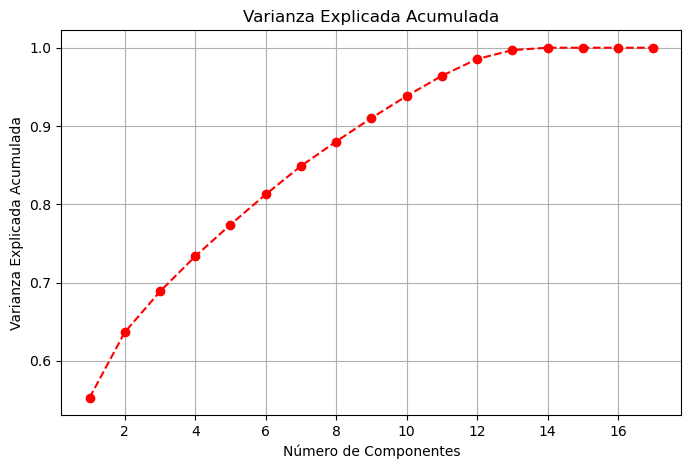

In [56]:
pca=PCA()

pca.fit(rfm_clientes_locales_clean)

var_exp=pca.explained_variance_ratio_

# Graficar varianza acumulada
plt.figure(figsize=(8,5))
plt.plot(range(1, len(var_exp)+1), var_exp.cumsum(), marker='o', linestyle='--', color='red')
plt.ylabel('Varianza Explicada Acumulada')
plt.xlabel('Número de Componentes')
plt.title('Varianza Explicada Acumulada')
plt.grid()
plt.show()

In [57]:
componentes = transform_pca(rfm_clientes_locales_clean, 5)

dataframe_pca = pd.DataFrame(componentes, columns=['PC1', 'PC2','PC3','PC4','PC5'],index=rfm_clientes_locales_clean.index)

dataframe_pca.head()

,PC1,PC2,PC3,PC4,PC5
1,-0.166507,0.034653,0.320308,0.097443,-0.100628
2,-0.225233,-0.216347,-0.301811,-0.390178,0.204606
3,0.679060,0.311728,0.397675,0.026603,-0.024185
4,-0.528891,0.078460,0.284232,0.311761,-0.303863
5,0.512304,0.017170,0.460454,0.027821,0.015569


Para n_clusters = 2, el silhouette promedio es: 0.3373
Para n_clusters = 3, el silhouette promedio es: 0.2985
Para n_clusters = 4, el silhouette promedio es: 0.2286
Para n_clusters = 5, el silhouette promedio es: 0.2265
Para n_clusters = 6, el silhouette promedio es: 0.2325
Para n_clusters = 7, el silhouette promedio es: 0.2162
Para n_clusters = 8, el silhouette promedio es: 0.2252
Para n_clusters = 9, el silhouette promedio es: 0.2097
Para n_clusters = 10, el silhouette promedio es: 0.1825
Para n_clusters = 11, el silhouette promedio es: 0.1991
Para n_clusters = 12, el silhouette promedio es: 0.2028
Para n_clusters = 13, el silhouette promedio es: 0.2042
Para n_clusters = 14, el silhouette promedio es: 0.2075


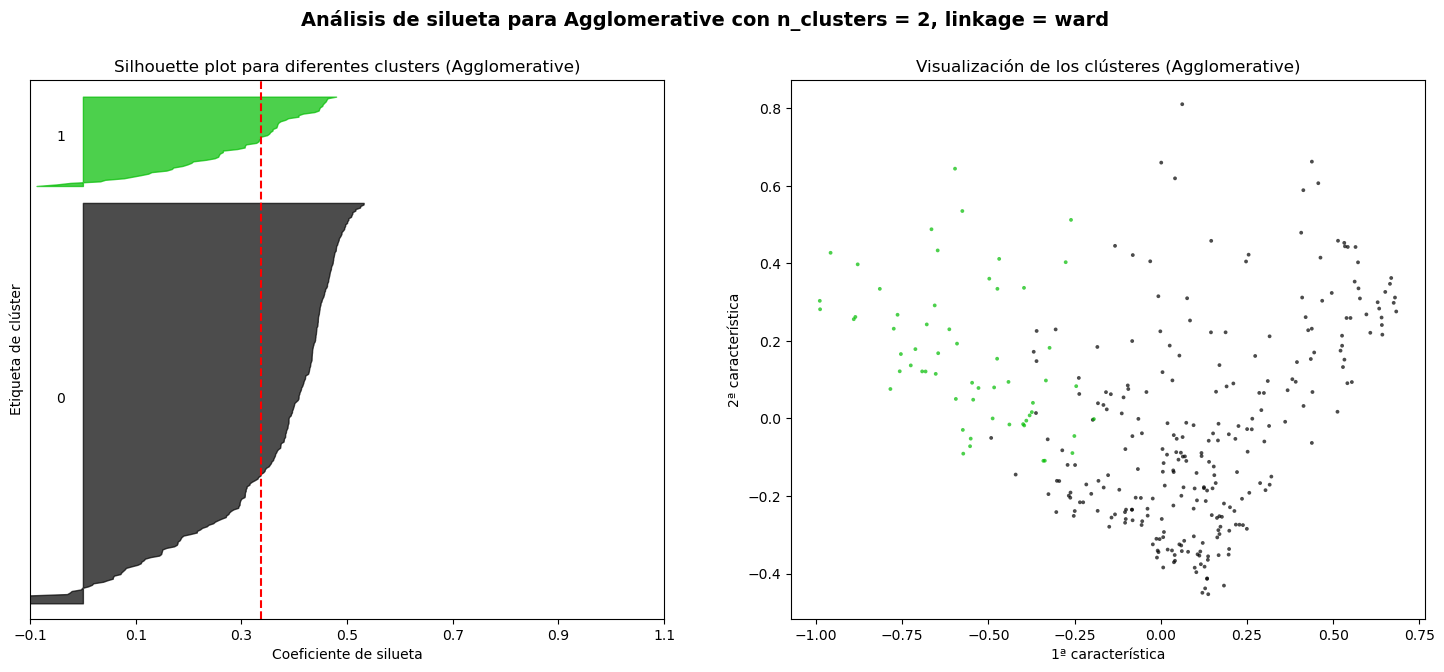

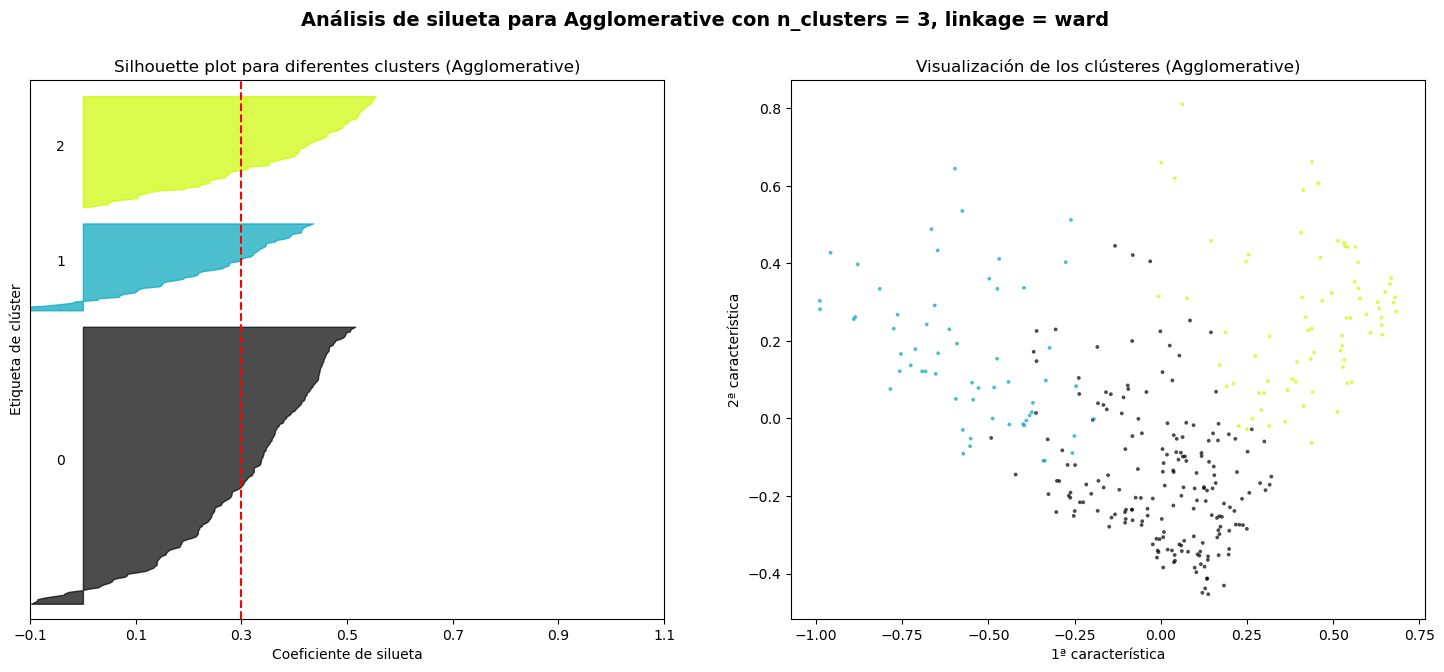

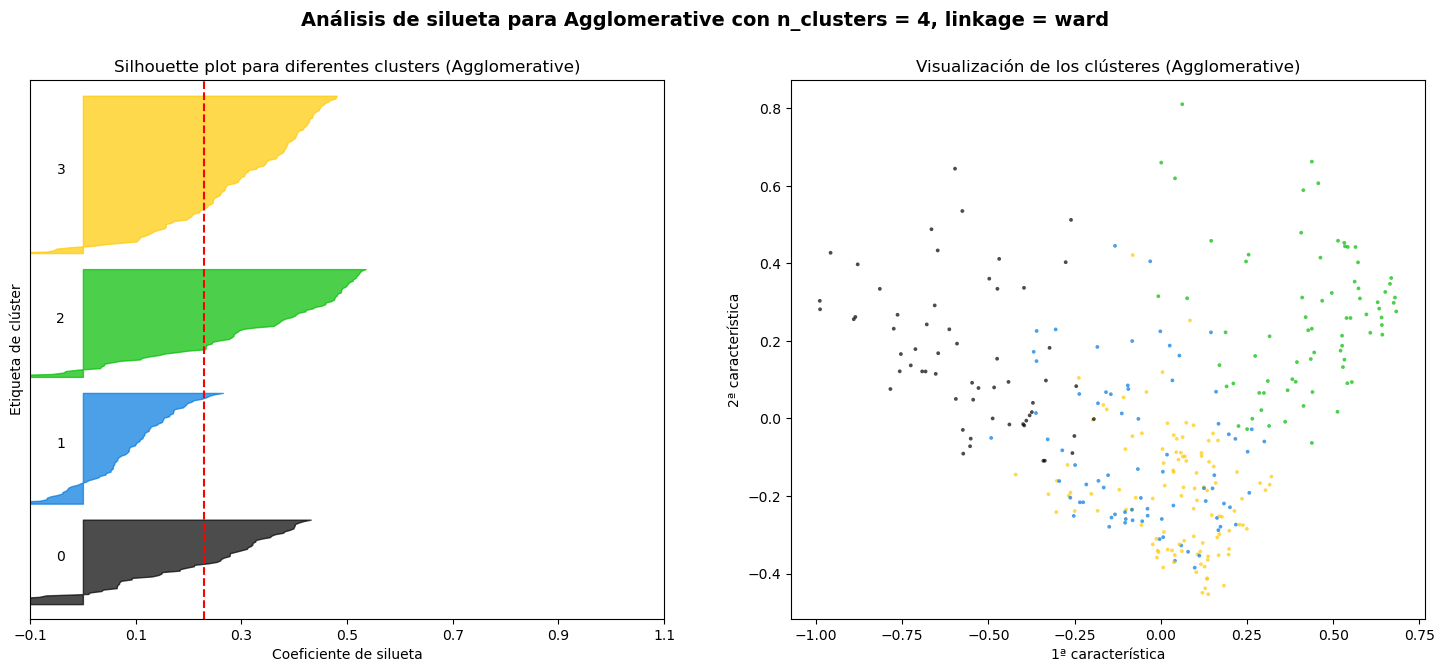

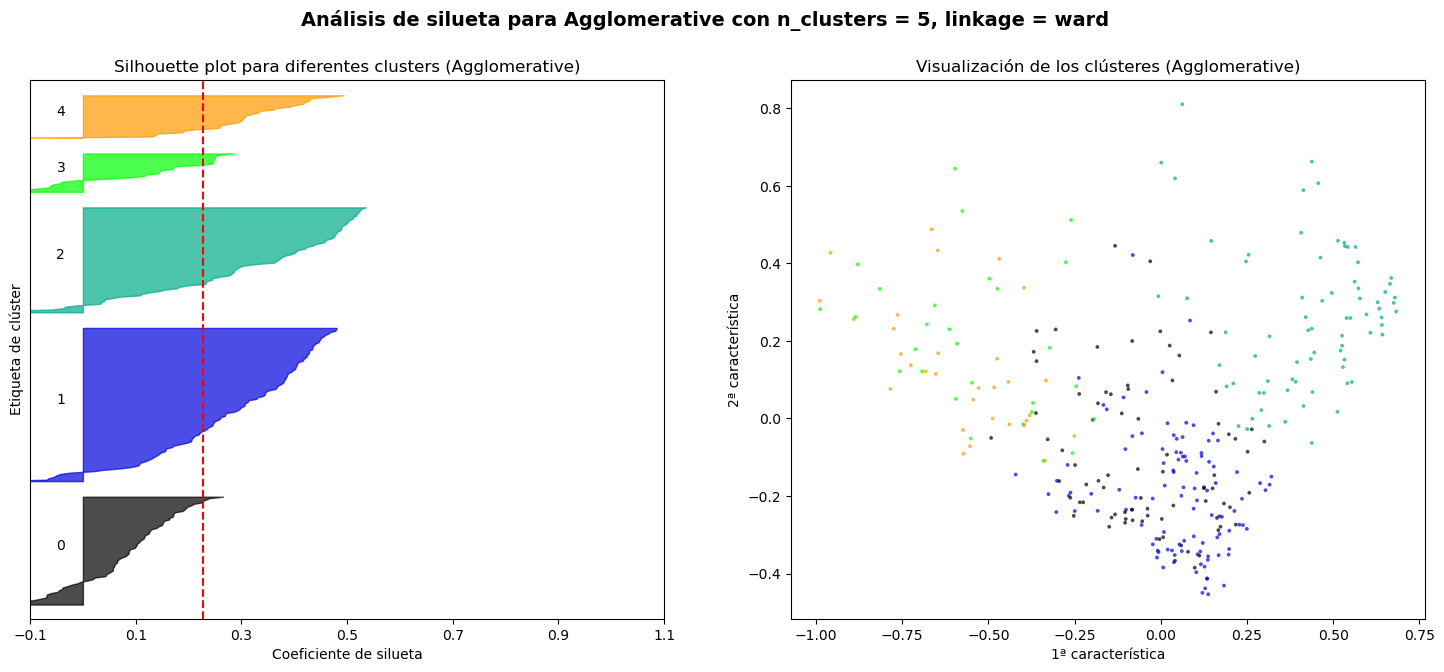

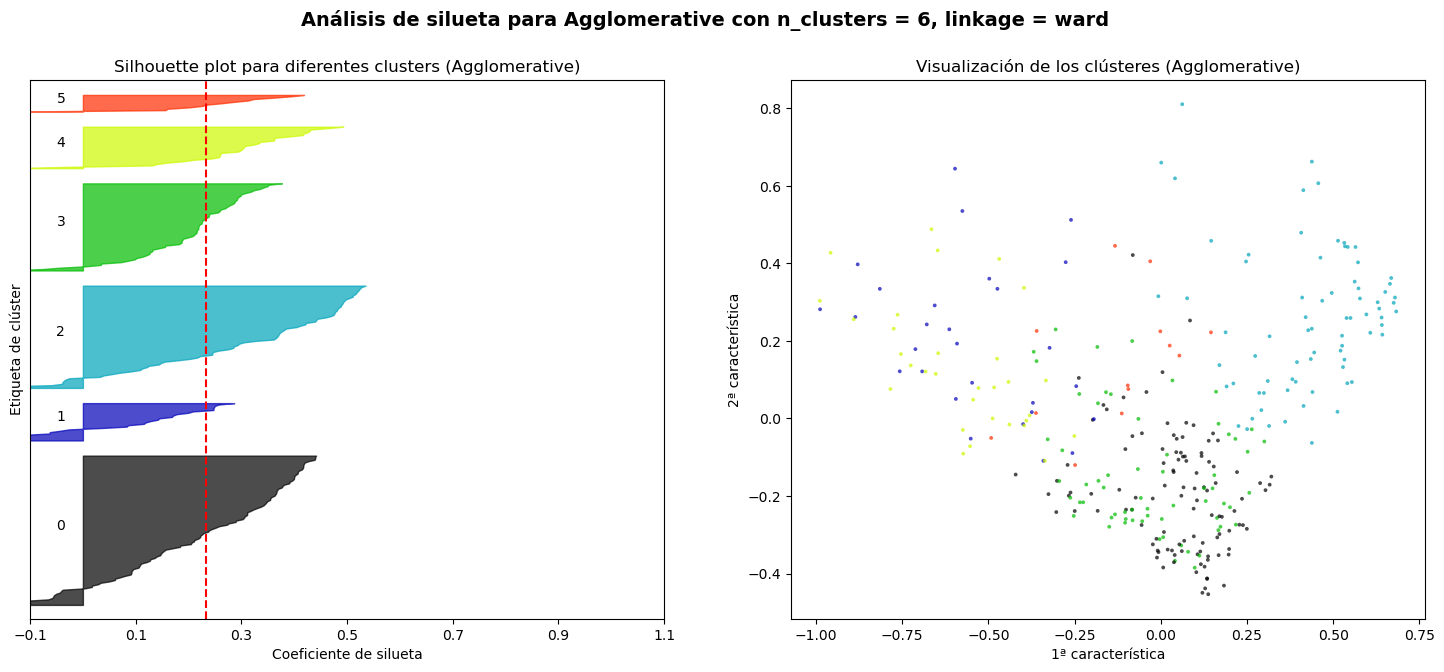

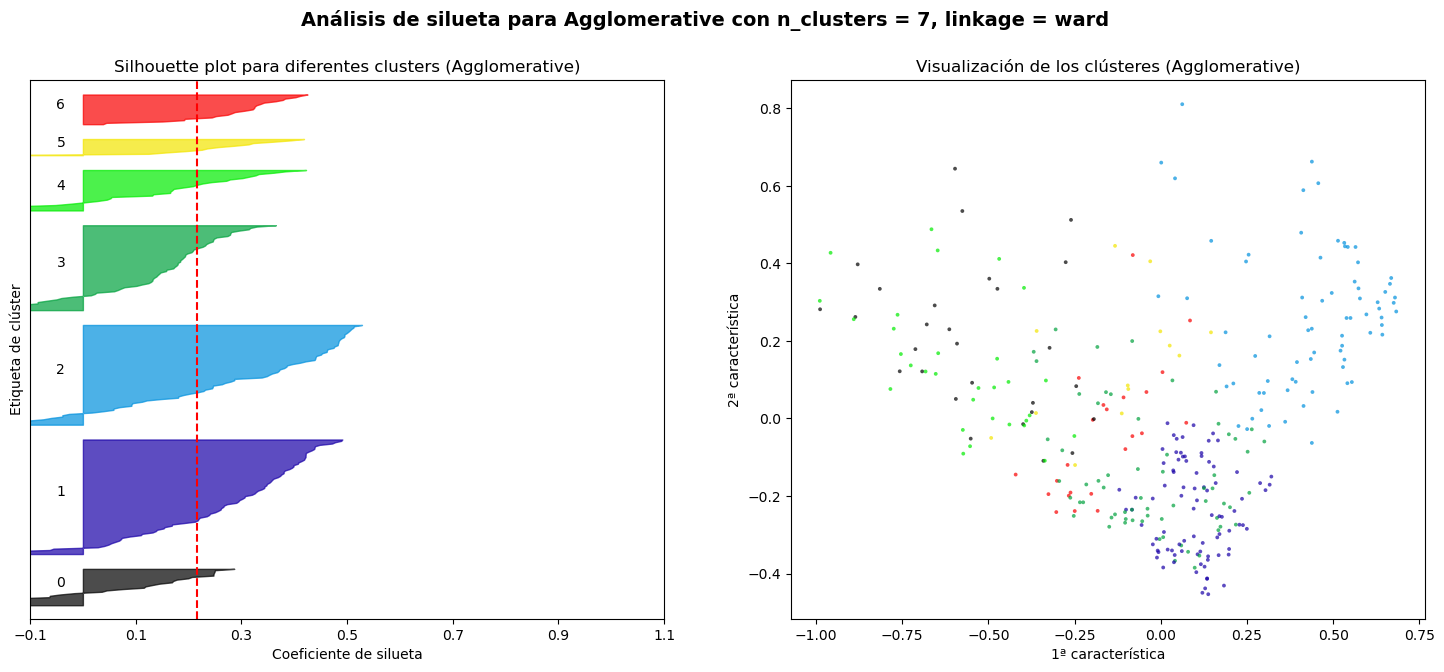

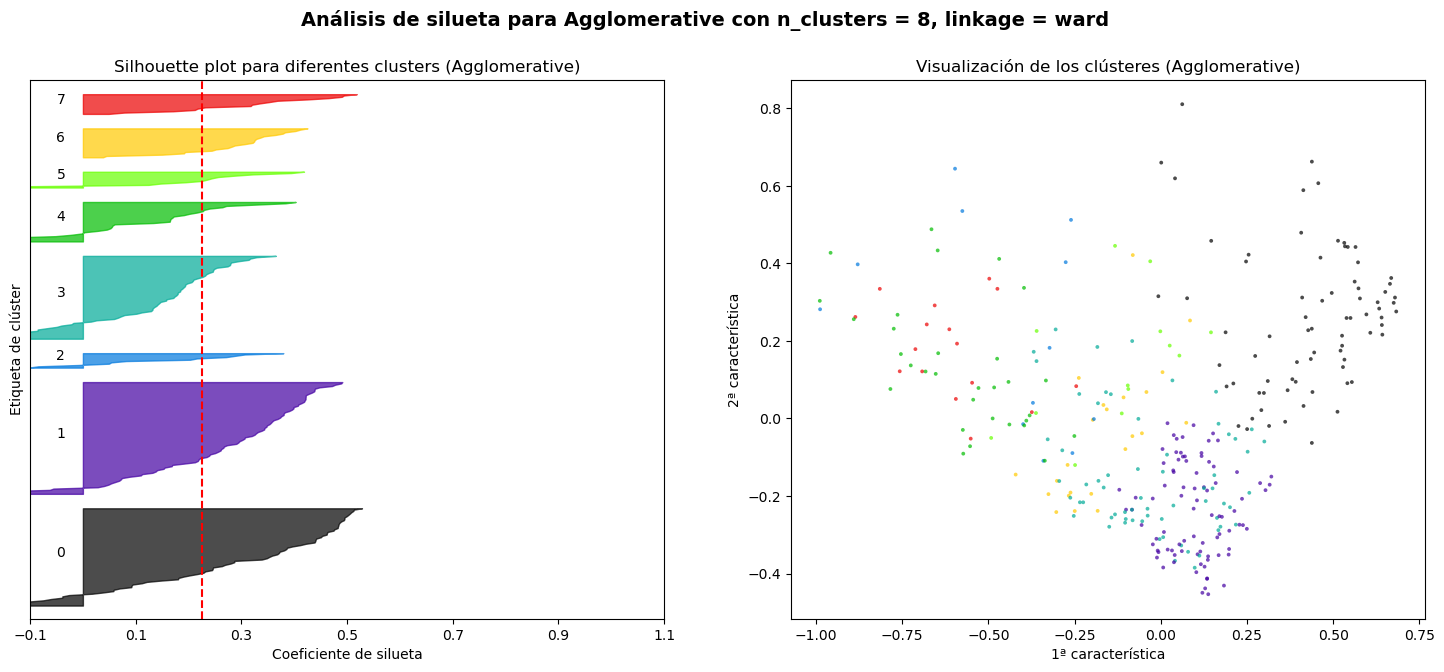

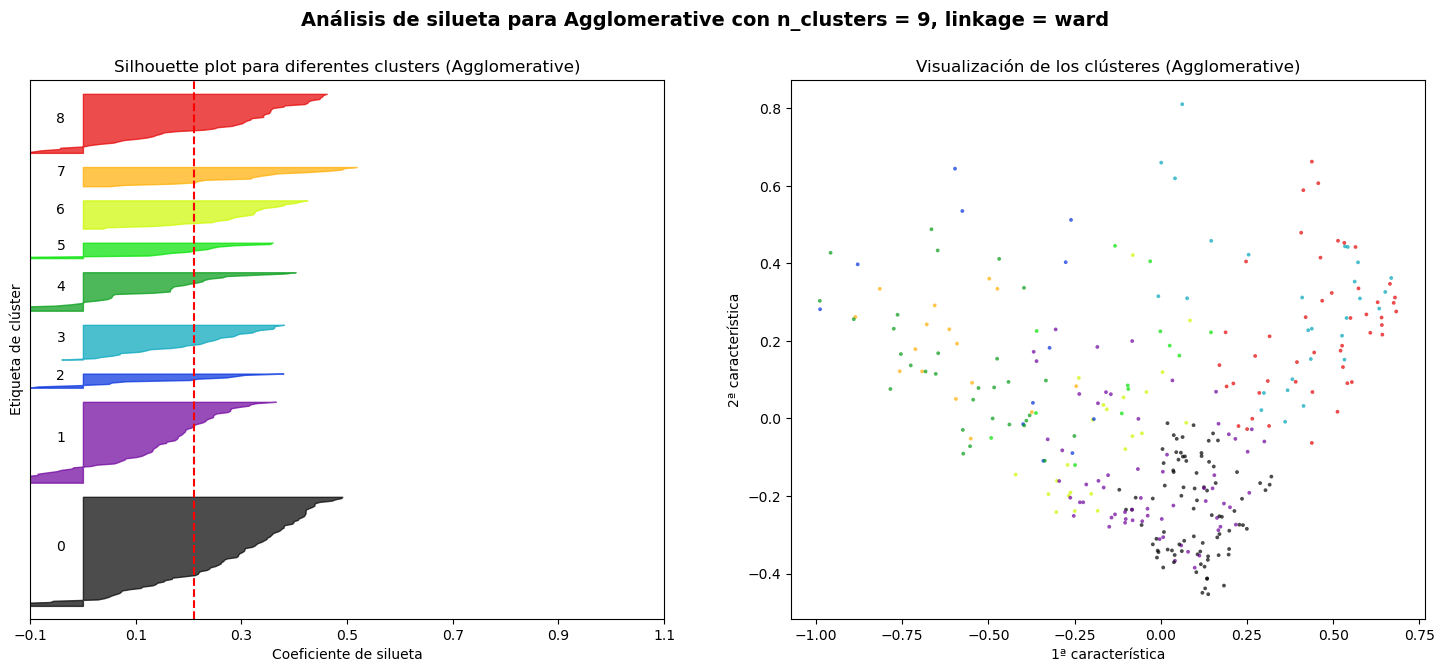

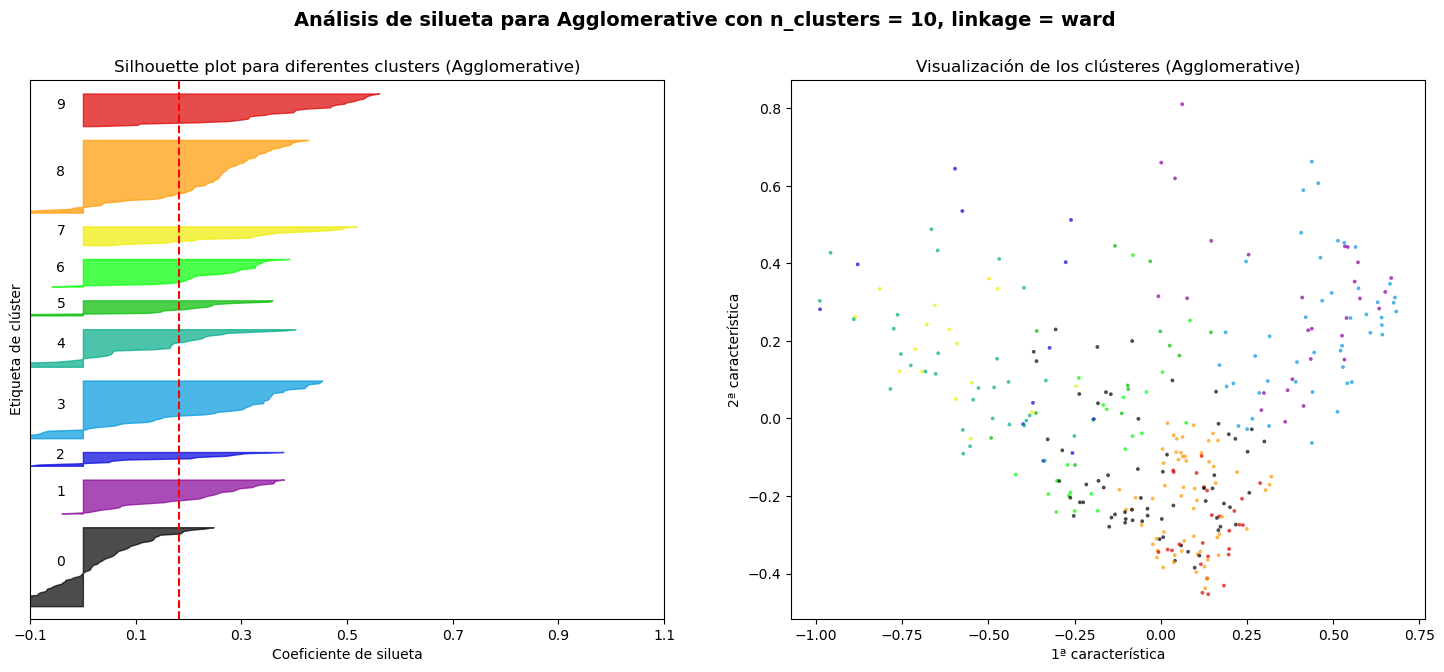

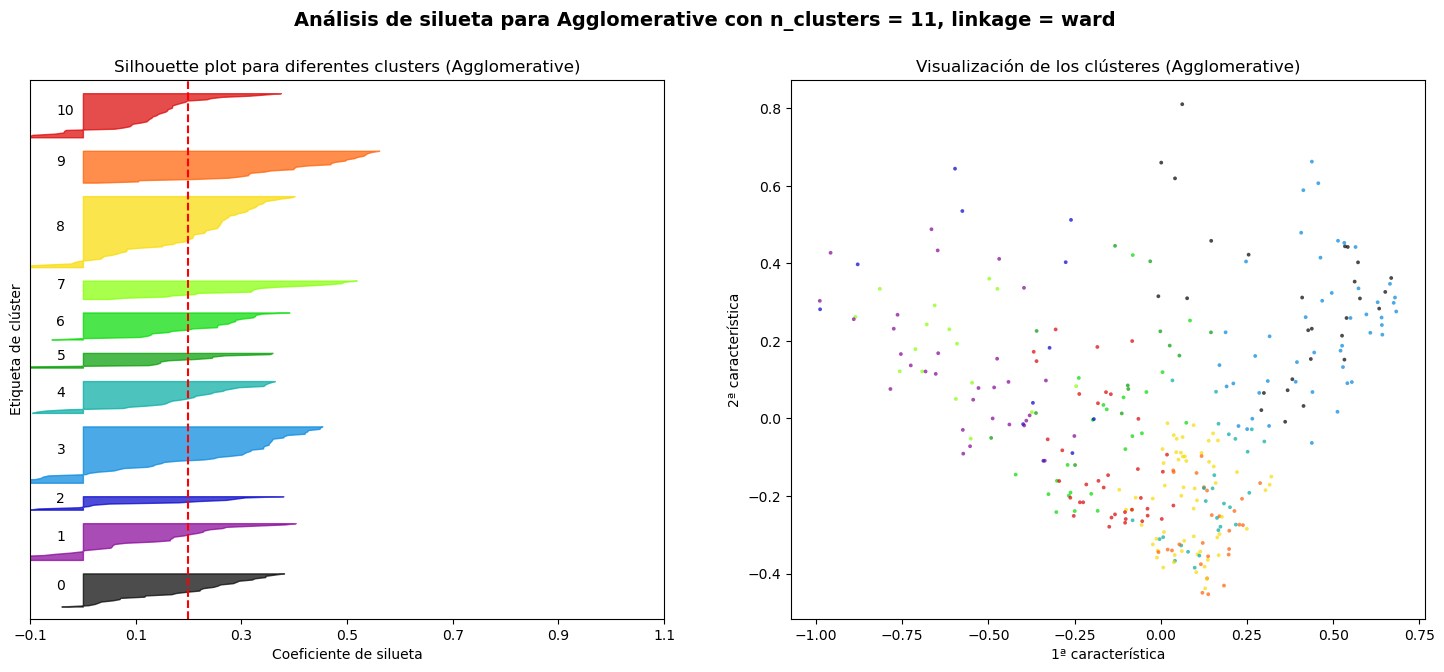

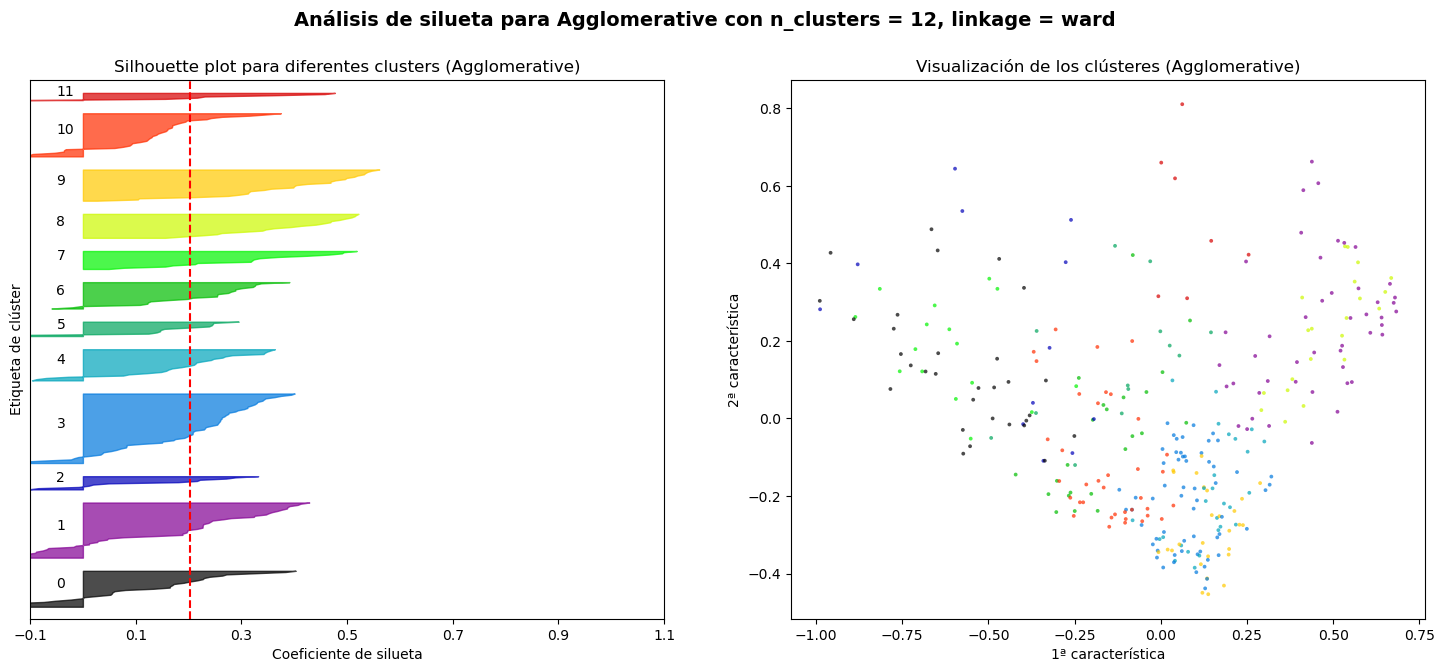

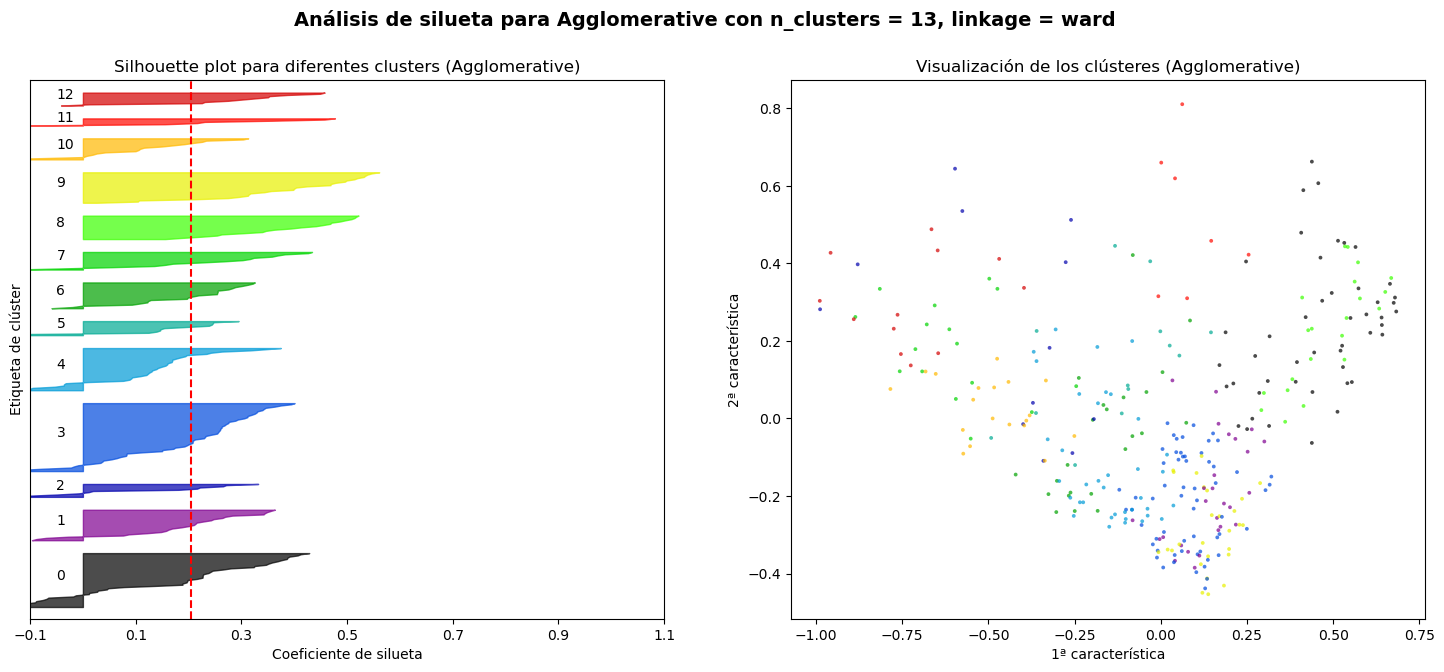

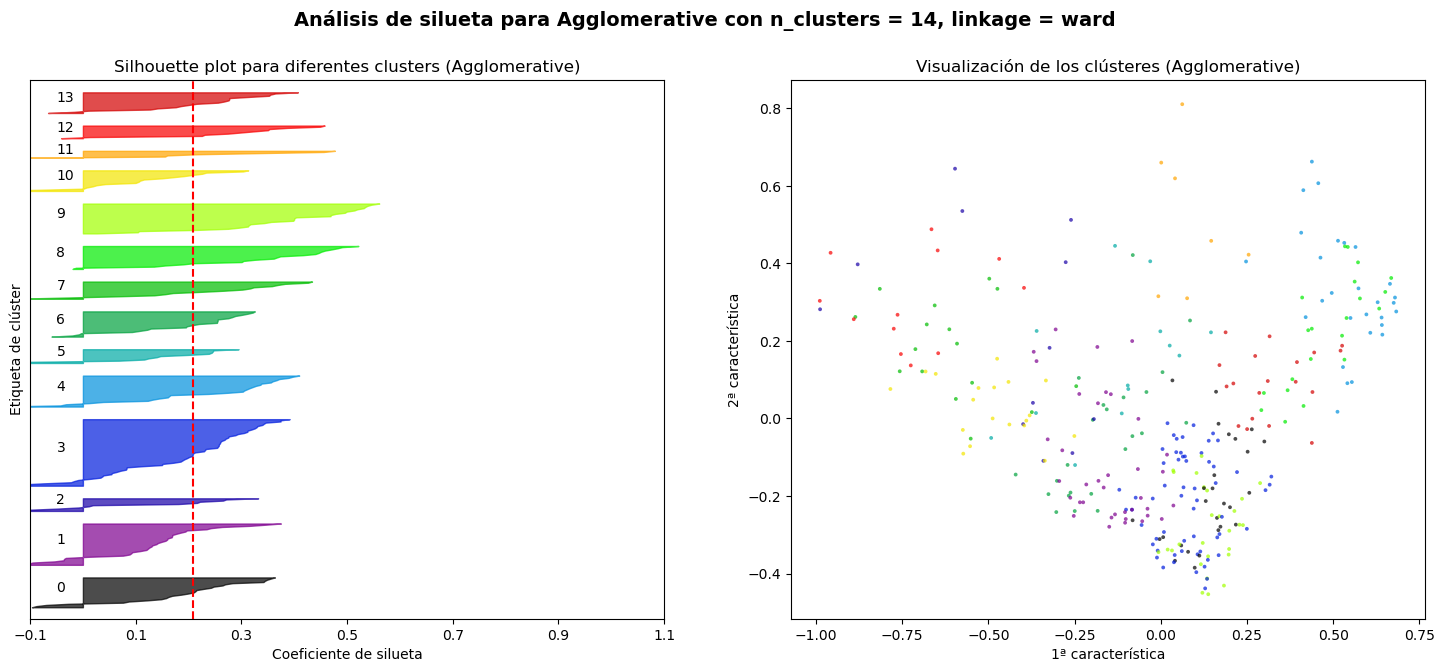

In [58]:
average_silhouette=silhouette_analysis_agglomerative(dataframe_pca.values, range(2, 15))

average_cluster=pd.DataFrame({'n_clusters':range(2,15),'average_silhouette':average_silhouette})

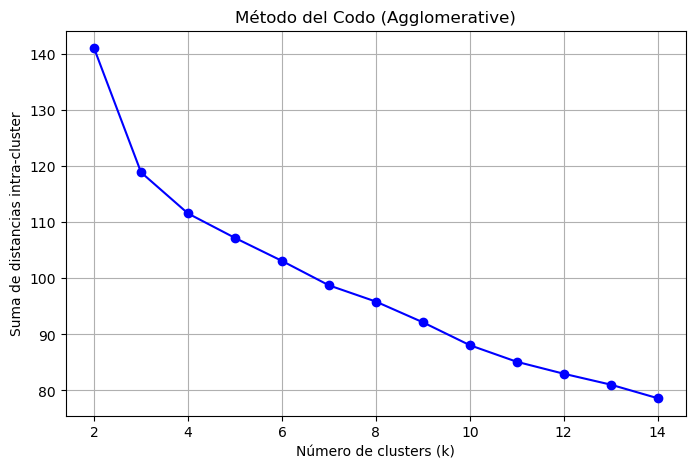

In [59]:
inertias=elbow_method_agglomerative(dataframe_pca.values, range(2, 15))

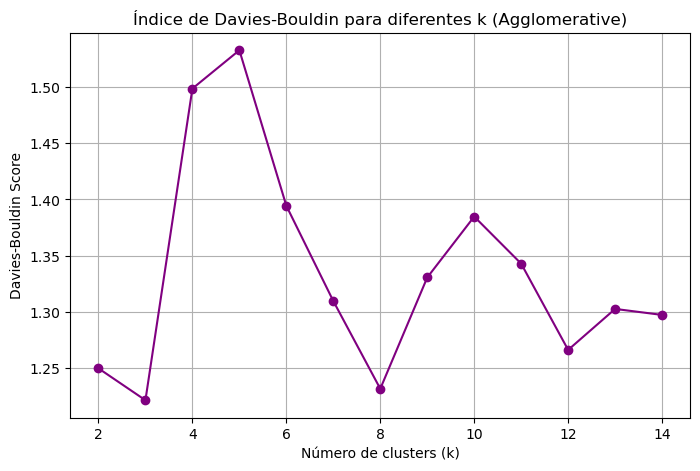

{2: np.float64(1.249961941580219), 3: np.float64(1.2216676204895238), 4: np.float64(1.4983874784311042), 5: np.float64(1.5324545531990554), 6: np.float64(1.3943276051890556), 7: np.float64(1.3097439577776755), 8: np.float64(1.2318210279357538), 9: np.float64(1.3306520910140998), 10: np.float64(1.3847378657028706), 11: np.float64(1.3429116487525399), 12: np.float64(1.266358543742829), 13: np.float64(1.3027421293714196), 14: np.float64(1.2974106360610398)}


In [60]:
db_scores=plot_davies_bouldin_scores_agglomerative(dataframe_pca.values, range(2, 15))

print(db_scores)

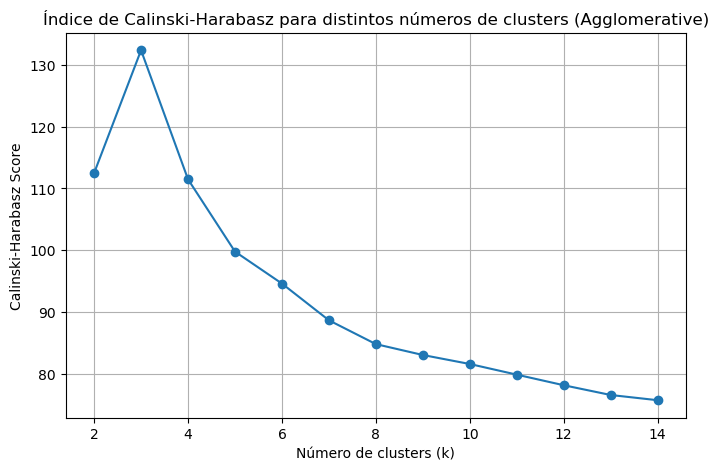

[np.float64(112.4869058963403), np.float64(132.3925377910082), np.float64(111.48967552461558), np.float64(99.78007536863065), np.float64(94.60149293884615), np.float64(88.65399498620692), np.float64(84.79783542707098), np.float64(83.0348612484253), np.float64(81.57683075336911), np.float64(79.85245936744369), np.float64(78.13812708059626), np.float64(76.55694861599237), np.float64(75.71289047245628)]


In [61]:
ch_scores=evaluar_calinski_harabasz_agglomerative(dataframe_pca.values, range(2, 15))

print(ch_scores)

Run ID final clustering: 8c1eaf7c01924d20801f4bbcc773ee59
🏃 View run Final_Clustering_agglomerative_k=3 at: http://localhost:5000/#/experiments/840918891029245684/runs/8c1eaf7c01924d20801f4bbcc773ee59
🧪 View experiment at: http://localhost:5000/#/experiments/840918891029245684


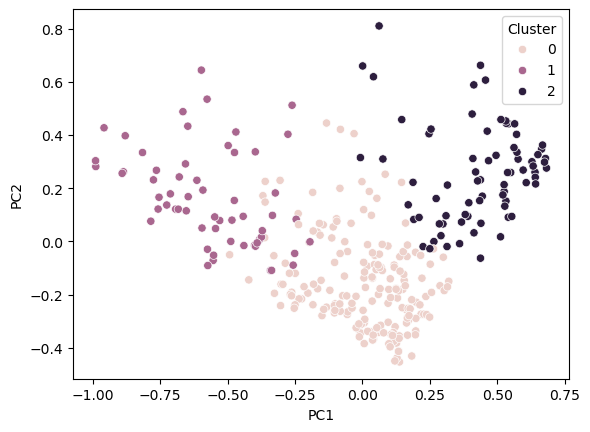

In [62]:
data_pca_cluster=run_agglomerative_mlflow(dataframe_pca, 3, 'ward', 'AGGLOMERATIVE-CLIENTES_EXTRANJEROS')


sns.scatterplot(data=data_pca_cluster,x='PC1',y='PC2',hue='Cluster')
plt.show()



In [63]:
data_pca_cluster

,PC1,PC2,PC3,PC4,PC5,Cluster
1,-0.166507,0.034653,0.320308,0.097443,-0.100628,0
2,-0.225233,-0.216347,-0.301811,-0.390178,0.204606,0
3,0.679060,0.311728,0.397675,0.026603,-0.024185,2
4,-0.528891,0.078460,0.284232,0.311761,-0.303863,1
5,0.512304,0.017170,0.460454,0.027821,0.015569,2
...,...,...,...,...,...,...
413,-0.132874,0.445047,-0.363831,-0.674213,-0.232508,0
414,0.562137,0.352835,-0.377357,0.030591,-0.013102,2
415,-0.328158,-0.053952,-0.385782,0.046072,0.011969,0
416,0.564619,0.442068,0.026324,0.002874,-0.061769,2


In [64]:
id_cliente.index = data_pca_cluster.index

In [65]:
data_pca_cluster['id_cliente'] = id_cliente

In [66]:
data_pca_cluster = data_pca_cluster[['id_cliente', 'PC1', 'PC2','PC3','PC4','PC5', 'Cluster']]

data_pca_cluster.head()

,id_cliente,PC1,PC2,PC3,PC4,PC5,Cluster
1,12348.0,-0.166507,0.034653,0.320308,0.097443,-0.100628,0
2,12349.0,-0.225233,-0.216347,-0.301811,-0.390178,0.204606,0
3,12350.0,0.679060,0.311728,0.397675,0.026603,-0.024185,2
4,12352.0,-0.528891,0.078460,0.284232,0.311761,-0.303863,1
5,12353.0,0.512304,0.017170,0.460454,0.027821,0.015569,2


In [67]:
rfm_clientes_locales_clean['Cluster']=data_pca_cluster['Cluster']
rfm_clientes_locales_clean['id_cliente']=id_cliente


In [68]:
rfm_clientes_locales_clean.head()

,Recency,Frequency,Monetary,horario_promedio,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,Cluster,id_cliente
1,76,4,1437.24,15,652.8,187.44,0.0,0.00,327.0,0.0,0.0,0.0,0.0,270.0,0.0,0.00,0.0,0,12348.0
2,19,1,1457.55,9,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1457.55,0.0,0,12349.0
3,311,1,294.40,16,0.0,0.00,294.4,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,2,12350.0
4,37,7,1385.74,14,0.0,0.00,296.5,345.01,0.0,0.0,0.0,0.0,0.0,512.5,0.0,231.73,0.0,1,12352.0
5,205,1,89.00,17,0.0,0.00,0.0,0.00,0.0,89.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,2,12353.0


In [69]:
rfm_clientes_locales_clean.columns

Index(['Recency', 'Frequency', 'Monetary', 'horario_promedio', '2010-12',
       '2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
       '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12',
       'Cluster', 'id_cliente'],
      dtype='object')

In [70]:
cluster_summary = rfm_clientes_locales_clean.groupby('Cluster').mean(numeric_only=True)
display(cluster_summary)

,Recency,Frequency,Monetary,horario_promedio,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,id_cliente
Cluster,,,,,,,,,,,,,,,,,,
0,54.897849,2.059140,774.177742,12.032258,10.903280,32.061129,26.069409,26.904247,20.609462,31.667903,47.003925,78.379032,68.858763,118.560108,147.762043,119.323441,46.07500,12817.408602
1,33.508475,5.033898,2307.610847,12.288136,79.925763,144.222712,106.994237,216.847966,78.594407,156.493390,242.809153,94.555763,244.795254,267.762881,246.046441,389.926102,38.63678,12797.389831
2,234.826667,1.373333,686.130800,12.333333,83.611333,88.139333,103.798933,86.454533,118.936533,93.373067,54.535467,57.281600,0.000000,0.000000,0.000000,0.000000,0.00000,12992.053333


In [71]:
cluster_summary.columns

Index(['Recency', 'Frequency', 'Monetary', 'horario_promedio', '2010-12',
       '2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
       '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12',
       'id_cliente'],
      dtype='object')

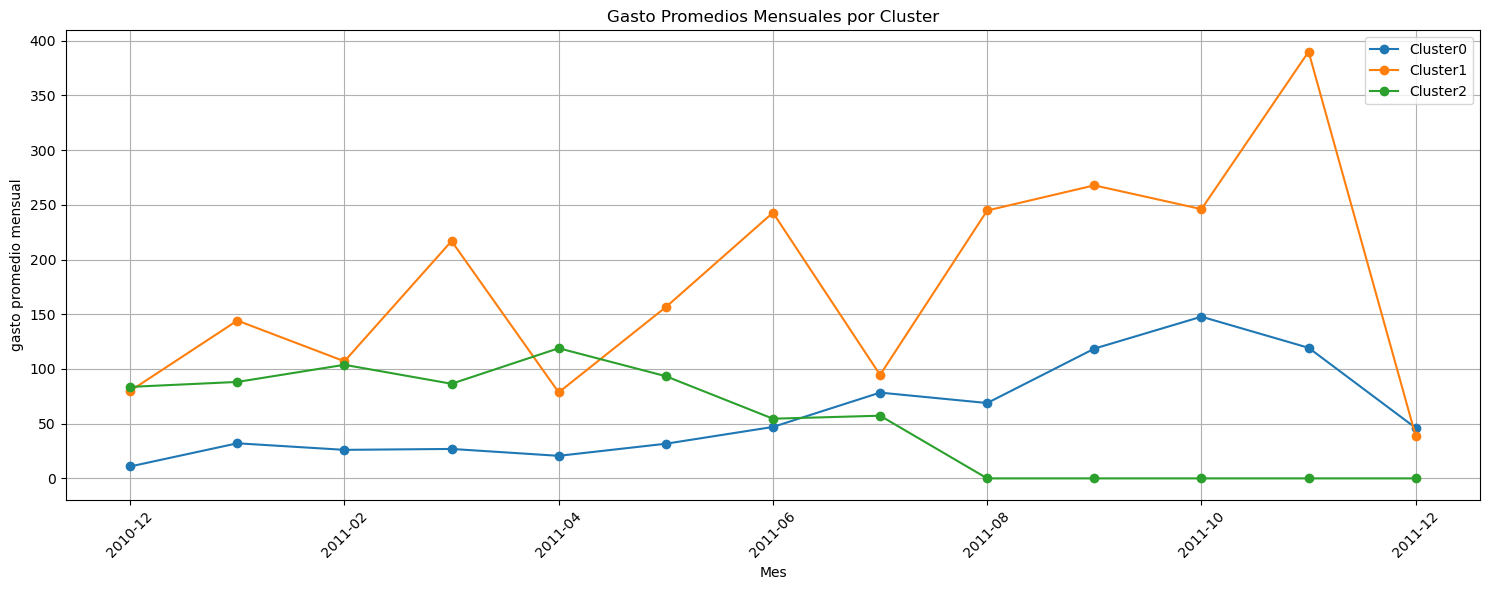

In [72]:
cluster0_mes= cluster_summary.iloc[0].T
cluster1_mes= cluster_summary.iloc[1].T
cluster2_mes= cluster_summary.iloc[2].T

columnas_fechas = [col for col in rfm_clientes_locales_clean.columns if col.startswith('201')]

cluster0_mes=cluster0_mes[columnas_fechas]
cluster1_mes=cluster1_mes[columnas_fechas]
cluster2_mes=cluster2_mes[columnas_fechas]

ventas_promedios_mensuales=pd.concat([cluster0_mes,cluster1_mes,cluster2_mes],axis=1)
ventas_promedios_mensuales.columns=['Cluster0','Cluster1','Cluster2']

ventas_promedios_mensuales.plot(
    figsize=(15, 6),
    title='Gasto Promedios Mensuales por Cluster',
    marker='o' ,
    markersize=6 )

plt.xlabel("Mes")
plt.ylabel("gasto promedio mensual")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [73]:
rfm_columnas=['Recency', 'Frequency', 'Monetary']
cluster0_rfm=cluster_summary.iloc[0].T
cluster1_rfm=cluster_summary.iloc[1].T
cluster2_rfm=cluster_summary.iloc[2].T

cluster0_rfm=cluster0_rfm[rfm_columnas]
cluster1_rfm=cluster1_rfm[rfm_columnas]
cluster2_rfm=cluster2_rfm[rfm_columnas]

rfm_promedio_cluster=pd.concat([cluster0_rfm,cluster1_rfm,cluster2_rfm],axis=1)
rfm_promedio_cluster.columns=['Cluster 0','Cluster 1','Cluster 2']


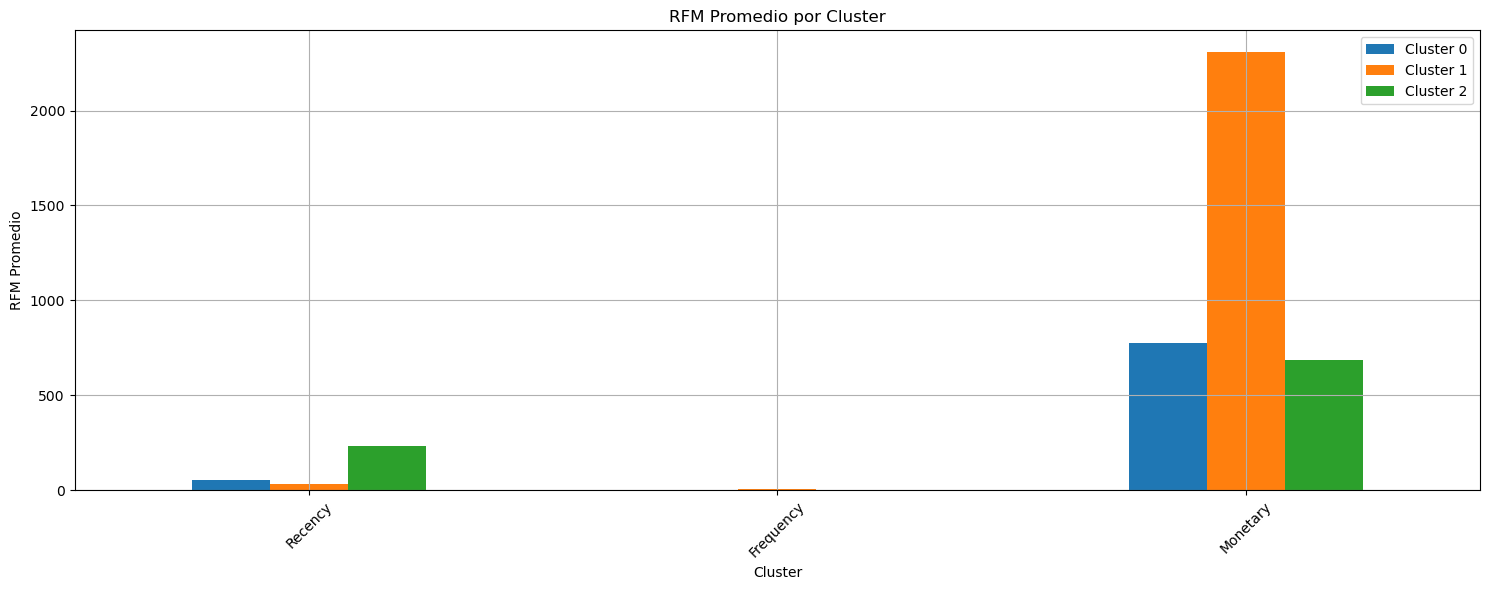

In [74]:
rfm_promedio_cluster.plot(kind='bar', figsize=(15, 6))
plt.title('RFM Promedio por Cluster')
plt.xlabel('Cluster')
plt.ylabel('RFM Promedio')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()